# Analysis of Yelp Business Intelligence Data

We will analyze a subset of Yelp's business, reviews and user data. This dataset comes to us from [Kaggle](https://www.kaggle.com/yelp-dataset/yelp-dataset) although we have taken steps to pull this data into a publis s3 bucket: `s3://sta9760-yelpdataset/yelp-light/*business.json`

# Installation and Initial Setup

Begin by installing the necessary libraries that you may need to conduct your analysis. At the very least, you must install `pandas` and `matplotlib`

In [1]:
sc.install_pypi_package("pandas==1.0.3")

sc.install_pypi_package("matplotlib==3.2.1")

sc.install_pypi_package("scipy==1.7.1")

sc.install_pypi_package("seaborn==0.10.0")

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
3,application_1638494217309_0004,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

  Using cached https://files.pythonhosted.org/packages/4a/6a/94b219b8ea0f2d580169e85ed1edc0163743f55aaeca8a44c2e8fc1e344e/pandas-1.0.3-cp37-cp37m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/36/7a/87837f39d0296e723bb9b62bbb257d0355c7f6128853c78955f57342a56d/python_dateutil-2.8.2-py2.py3-none-any.whl

  Using cached https://files.pythonhosted.org/packages/b2/c2/71fcf957710f3ba1f09088b35776a799ba7dd95f7c2b195ec800933b276b/matplotlib-3.2.1-cp37-cp37m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/a0/34/895006117f6fce0b4de045c87e154ee4a20c68ec0a4c9a36d900888fb6bc/pyparsing-3.0.6-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/5c/f9/695d6bedebd747e5eb0fe8fad57b72fdf25411273a39791cde838d5a8f51/cycler-0.11.0-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/09/6b/6e567cb2e86d4e5939a9233f8734e26021b6a9c1bc4b1edccba236a84cc2/kiwisolver-1.3.2-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_

## Importing

Now, import the installed packages from the previous block below.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Loading Data

We are finally ready to load data. Using `spark` load the data from S3 into a `dataframe` object that we can manipulate further down in our analysis.

In [3]:
business = spark.read.json('s3://sta9760akhila/yelp_academic_dataset_business.json')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Overview of Data

Display the number of rows and columns in our dataset.

In [4]:
print(f'Total Rows: {business.count()} | Total Columns: {len(business.dtypes)}')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Total Rows: 160585 | Total Columns: 14

Display the DataFrame schema below.

In [5]:
business.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- address: string (nullable = true)
 |-- attributes: struct (nullable = true)
 |    |-- AcceptsInsurance: string (nullable = true)
 |    |-- AgesAllowed: string (nullable = true)
 |    |-- Alcohol: string (nullable = true)
 |    |-- Ambience: string (nullable = true)
 |    |-- BYOB: string (nullable = true)
 |    |-- BYOBCorkage: string (nullable = true)
 |    |-- BestNights: string (nullable = true)
 |    |-- BikeParking: string (nullable = true)
 |    |-- BusinessAcceptsBitcoin: string (nullable = true)
 |    |-- BusinessAcceptsCreditCards: string (nullable = true)
 |    |-- BusinessParking: string (nullable = true)
 |    |-- ByAppointmentOnly: string (nullable = true)
 |    |-- Caters: string (nullable = true)
 |    |-- CoatCheck: string (nullable = true)
 |    |-- Corkage: string (nullable = true)
 |    |-- DietaryRestrictions: string (nullable = true)
 |    |-- DogsAllowed: string (nullable = true)
 |    |-- DriveThru: string (nullable = true)
 |    |-- GoodForDancing: str

Display the first 5 rows with the following columns:

* `business_id`
* `name`
* `city`
* `state`
* `categories`

In [6]:
business.select('business_id', 'name', 'city', 'state', 'categories').show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------------+-----------+-----+--------------------+
|         business_id|                name|       city|state|          categories|
+--------------------+--------------------+-----------+-----+--------------------+
|6iYb2HFDywm3zjuRg...| Oskar Blues Taproom|    Boulder|   CO|Gastropubs, Food,...|
|tCbdrRPZA0oiIYSmH...|Flying Elephants ...|   Portland|   OR|Salad, Soup, Sand...|
|bvN78flM8NLprQ1a1...|      The Reclaimory|   Portland|   OR|Antiques, Fashion...|
|oaepsyvc0J17qwi8c...|         Great Clips|Orange City|   FL|Beauty & Spas, Ha...|
|PE9uqAjdw0E4-8mjG...|   Crossfit Terminus|    Atlanta|   GA|Gyms, Active Life...|
+--------------------+--------------------+-----------+-----+--------------------+
only showing top 5 rows

# Analyzing Categories

Let's now answer this question: **how many unique categories are represented in this dataset?**

Essentially, we have the categories per business as a list - this is useful to quickly see what each business might be represented as but it is difficult to easily answer questions such as:

* How many businesses are categorized as `Active Life`, for instance
* What are the top 20 most popular categories available?

## Association Table

We need to "break out" these categories from the business ids? One common approach to take is to build an association table mapping a single business id multiple times to each distinct category.

For instance, given the following:


| business_id | categories |
|-------------|------------|
| abcd123     | a,b,c      |

We would like to derive something like:

| business_id | category |
|-------------|------------|
| abcd123     | a          |
| abcd123     | b          |
| abcd123     | c          |


What this does is allow us to then perform a myriad of rollups and other analysis on this association table which can aid us in answering the questions asked above.

Implement the code necessary to derive the table described from your original yelp dataframe.

In [7]:
from pyspark.sql.functions import split, explode

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [8]:
categories = business.select('business_id', 
                             explode(split(business.categories, ', ')).alias('category'))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Display the first 5 rows of your association table below.

In [9]:
categories.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+------------+
|         business_id|    category|
+--------------------+------------+
|6iYb2HFDywm3zjuRg...|  Gastropubs|
|6iYb2HFDywm3zjuRg...|        Food|
|6iYb2HFDywm3zjuRg...|Beer Gardens|
|6iYb2HFDywm3zjuRg...| Restaurants|
|6iYb2HFDywm3zjuRg...|        Bars|
+--------------------+------------+
only showing top 5 rows

## Total Unique Categories

Finally, we are ready to answer the question: **what is the total number of unique categories available?**

Below, implement the code necessary to calculate this figure.

In [10]:
categories.select('category').distinct().count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

1330

## Top Categories By Business

Now let's find the top categories in this dataset by rolling up categories.

### Counts of Businesses / Category

So now, let's unroll our distinct count a bit and display the per count value of businesses per category.

The expected output should be:

| category | count |
|-------------|------------|
| a     | 15         |
| b     | 2          |
| c     | 45          |

Or something to that effect.

In [11]:
category_counts = categories.groupBy('category').count()

category_counts.show(20)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-----+
|            category|count|
+--------------------+-----+
|      Dermatologists|  351|
|      Paddleboarding|   67|
|        Aerial Tours|    8|
|         Hobby Shops|  610|
|          Bubble Tea|  779|
|             Embassy|    9|
|             Tanning|  701|
|            Handyman|  507|
|      Aerial Fitness|   13|
|             Falafel|  141|
|        Summer Camps|  308|
|       Outlet Stores|  184|
|     Clothing Rental|   37|
|      Sporting Goods| 1864|
|     Cooking Schools|  114|
|  College Counseling|   20|
|  Lactation Services|   47|
|Ski & Snowboard S...|   55|
|             Museums|  336|
|              Doulas|   52|
+--------------------+-----+
only showing top 20 rows

### Bar Chart of Top Categories

With this data available, let us now build a barchart of the top 20 categories. 

**HINT**: don't forget about the matplotlib magic!

```
%matplot plt
```

In [12]:
top_categories = category_counts.toPandas()
top_categories.sort_values('count',inplace=True)
top_categories=top_categories.tail(20)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

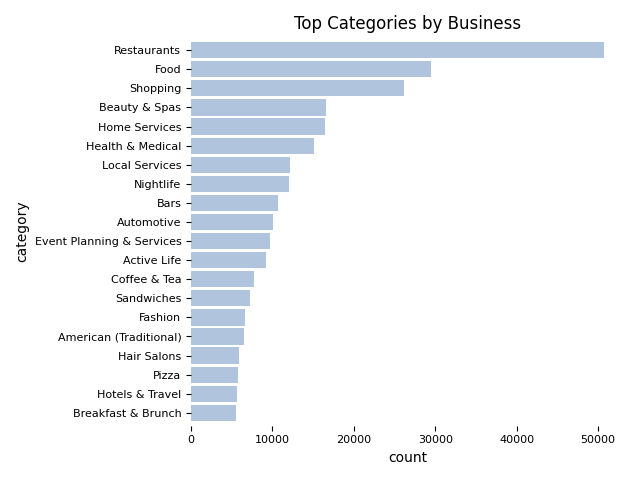

In [13]:
top_c_plot = top_categories.plot(kind='barh',y='count',x='category',
            color='lightsteelblue',title='Top Categories by Business', legend=False, 
                   fontsize=8, width=0.85)
plt.xlabel('count')
plt.ylabel('category')
plt.tight_layout()

top_c_plot.spines["top"].set_visible(False)
top_c_plot.spines["right"].set_visible(False)
top_c_plot.spines["left"].set_visible(False)
top_c_plot.spines["bottom"].set_visible(False)

%matplot plt

# Do Yelp Reviews Skew Negative?

Oftentimes, it is said that the only people who write a written review are those who are extremely _dissatisfied_ or extremely _satisfied_ with the service received. 

How true is this really? Let's try and answer this question.

## Loading User Data

Begin by loading the user data set from S3 and printing schema to determine what data is available.

In [14]:
review = spark.read.json('s3://sta9760akhila/yelp_academic_dataset_review.json')

review.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- business_id: string (nullable = true)
 |-- cool: long (nullable = true)
 |-- date: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- review_id: string (nullable = true)
 |-- stars: double (nullable = true)
 |-- text: string (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)

Let's begin by listing the `business_id` and `stars` columns together for the user reviews data.

In [15]:
review_business_stars = review.select('business_id', 'stars')

review_business_stars.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-----+
|         business_id|stars|
+--------------------+-----+
|buF9druCkbuXLX526...|  4.0|
|RA4V8pr014UyUbDvI...|  4.0|
|_sS2LBIGNT5NQb6PD...|  5.0|
|0AzLzHfOJgL7ROwhd...|  2.0|
|8zehGz9jnxPqXtOc7...|  4.0|
+--------------------+-----+
only showing top 5 rows

Now, let's aggregate along the `stars` column to get a resultant dataframe that displays _average stars_ per business as accumulated by users who **took the time to submit a written review**.

In [16]:
from pyspark.sql.functions import avg
avg_stars = review.groupby("business_id").avg("stars")
avg_stars.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-----------------+
|         business_id|       avg(stars)|
+--------------------+-----------------+
|yHtuNAlYKtRZniO8O...|4.714285714285714|
|R0IJhEI-zSJpYT1YN...|3.606060606060606|
|uEUweopM30lHcVxjO...|              3.0|
|L3WCfeVozu5etMhz4...|              4.2|
|XzXcpPCb8Y5huklEN...|4.666666666666667|
+--------------------+-----------------+
only showing top 5 rows

Now the fun part - let's join our two dataframes (reviews and business data) by `business_id`. 

In [17]:
df1 = avg_stars.select('business_id','avg(stars)')
df2 = business.select('business_id','stars','name','city','state')
business_review = df1.join(df2, df1.business_id == df2.business_id)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Let's see a few of these:

In [18]:
business_review = business_review.select('avg(stars)','stars','name','city','state')

business_review.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------------+-----+--------------------+----------+-----+
|        avg(stars)|stars|                name|      city|state|
+------------------+-----+--------------------+----------+-----+
|               5.0|  5.0|    CheraBella Salon|   Peabody|   MA|
|             3.875|  4.0|Mezcal Cantina & ...|  Columbus|   OH|
|3.8666666666666667|  4.0|    Red Table Coffee|    Austin|   TX|
|               5.0|  5.0|          WonderWell|    Austin|   TX|
|             3.375|  3.5|         Avalon Oaks|Wilmington|   MA|
+------------------+-----+--------------------+----------+-----+
only showing top 5 rows

Compute a new dataframe that calculates what we will call the _skew_ (for lack of a better word) between the avg stars accumulated from written reviews and the _actual_ star rating of a business (ie: the average of stars given by reviewers who wrote an actual review **and** reviewers who just provided a star rating).

The formula you can use is something like:

```
(row['avg(stars)'] - row['stars']) / row['stars']
```

If the **skew** is negative, we can interpret that to be: reviewers who left a written response were more dissatisfied than normal. If **skew** is positive, we can interpret that to be: reviewers who left a written response were more satisfied than normal.

In [19]:
skew_df = business_review.select('avg(stars)','stars').toPandas()
skew_df["skew"] = (skew_df['avg(stars)'] - skew_df['stars']) / skew_df['stars']

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

And finally, graph it!

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

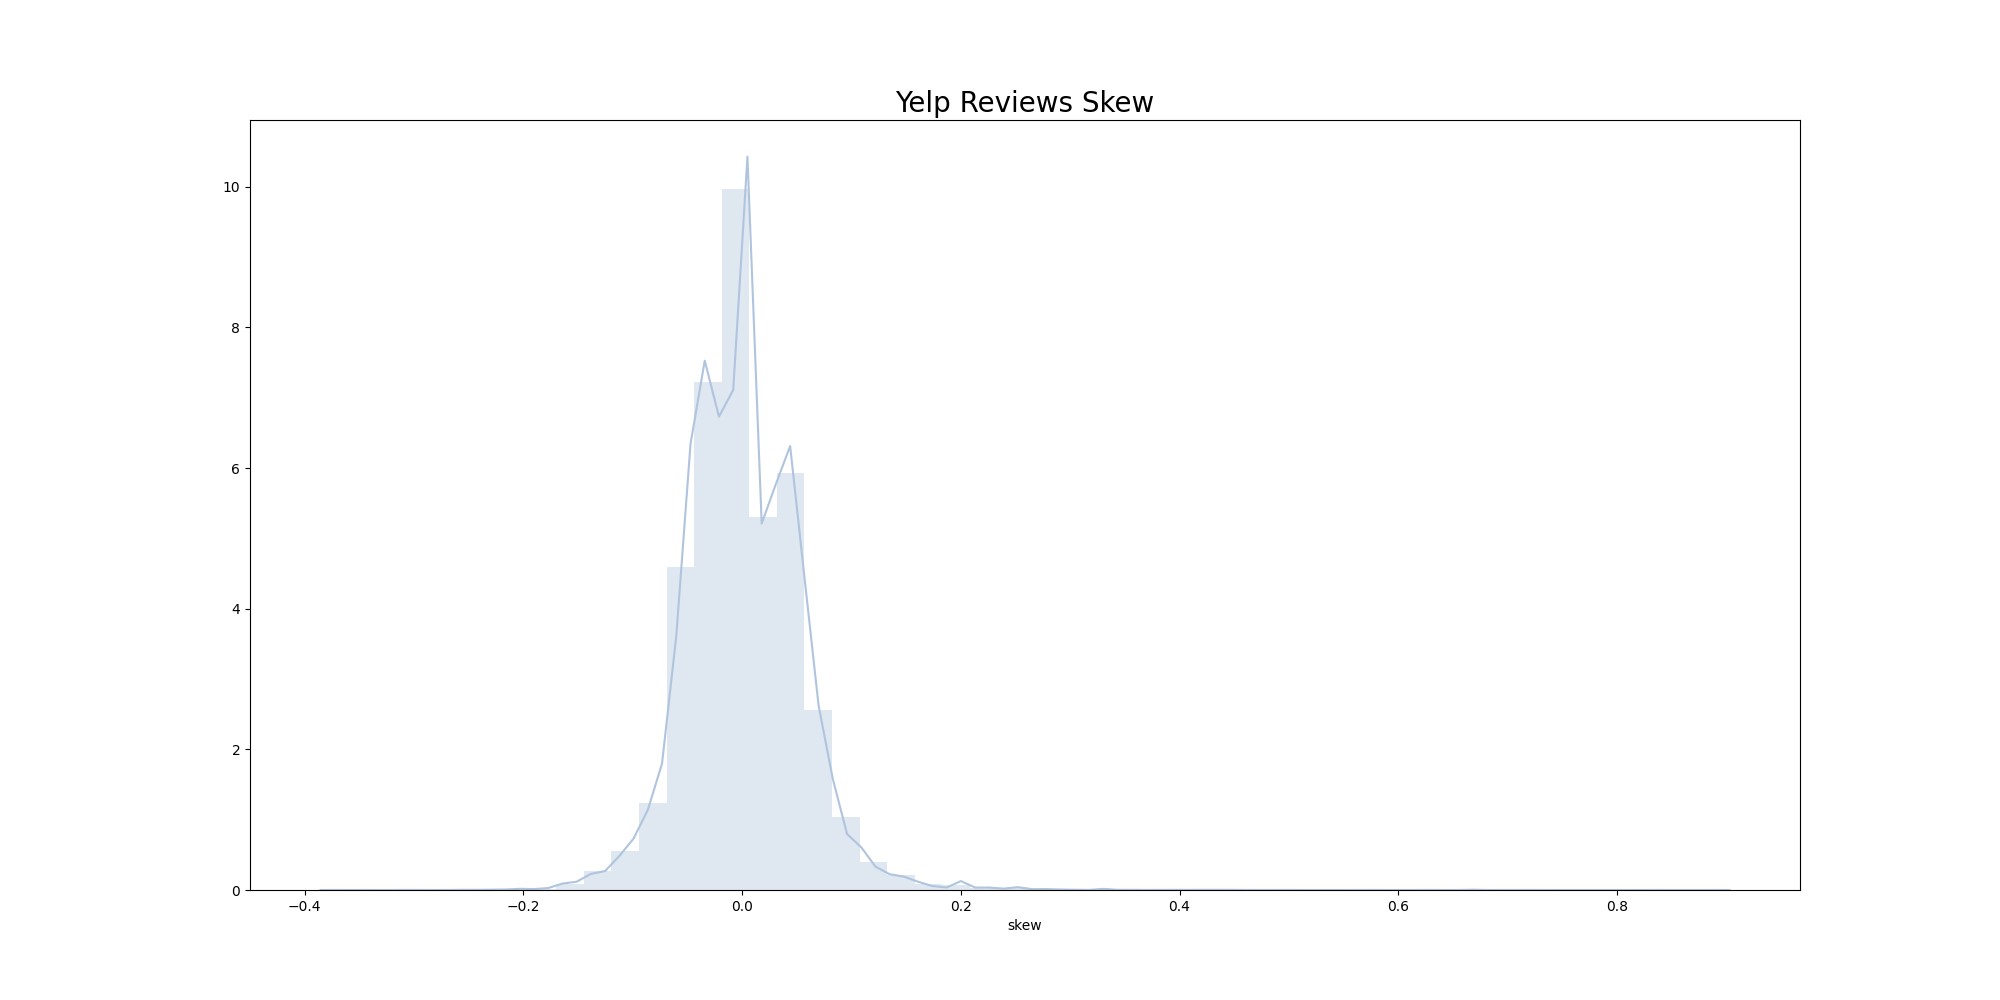

In [20]:
plt.figure(figsize=(20,10))
sns.distplot(skew_df["skew"], kde=True, color = 'lightsteelblue')
plt.title('Yelp Reviews Skew', size = 20)
%matplot plt

So, do Yelp (written) Reviews skew negative? Does this analysis actually prove anything? Expound on implications / interpretations of this graph. 

Yelp reviews appear to be slightly skewed the right, which means that they skew positive, not negative. It can interpreted that reviewers who wrote a written response were slightly more satisfied than normal.

# Should the Elite be Trusted? (Or, some other analysis of your choice)

For the final portion - you have a choice:

* Try and analyze some interesting dimension to this data. The **ONLY** requirement is that you must use the **Users** dataset and join on either the **business* or **reviews** dataset
* Or, you may try and answer the question posed: how accurate or close are the ratings of an "elite" user (check Users table schema) vs the actual business rating.

Feel free to use any and all methodologies at your disposal - only requirement is you must render one visualization in your analysis

### Loading the User Dataset

In [21]:
user= spark.read.json('s3://sta9760akhila/yelp_academic_dataset_user.json')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [22]:
user.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- average_stars: double (nullable = true)
 |-- compliment_cool: long (nullable = true)
 |-- compliment_cute: long (nullable = true)
 |-- compliment_funny: long (nullable = true)
 |-- compliment_hot: long (nullable = true)
 |-- compliment_list: long (nullable = true)
 |-- compliment_more: long (nullable = true)
 |-- compliment_note: long (nullable = true)
 |-- compliment_photos: long (nullable = true)
 |-- compliment_plain: long (nullable = true)
 |-- compliment_profile: long (nullable = true)
 |-- compliment_writer: long (nullable = true)
 |-- cool: long (nullable = true)
 |-- elite: string (nullable = true)
 |-- fans: long (nullable = true)
 |-- friends: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- name: string (nullable = true)
 |-- review_count: long (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)
 |-- yelping_since: string (nullable = true)

Selecting necessary columns from the User and Review dataset

In [23]:
elite = user.filter(user['elite'] != '').select('user_id', 'elite', 'average_stars')

review_cols = review.select('business_id', 'stars', 'user_id')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Joining User and Review datasets

In [24]:
elite_reviews = elite.join(review_cols, elite.user_id == review_cols.user_id).drop(review['user_id'])
elite_reviews.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------------+-------------+--------------------+-----+
|             user_id|               elite|average_stars|         business_id|stars|
+--------------------+--------------------+-------------+--------------------+-----+
|0JQYSCWOQWKqK7KMj...| 2015,2016,2017,2018|         3.83|eCLuYcTuQpDPFOezh...|  4.0|
|l91pXxTZGS5CNWjNB...|2012,2013,2014,20...|         3.53|RP_U_TyolABy3eYuR...|  3.0|
|WAyYDJKFMzlTTnKxq...|2011,2012,2013,20...|         3.65|_6TF9YiOiYSToPBRz...|  5.0|
|g34Qcj06LmCDhKzks...|2017,2018,2019,20,20|         3.99|bxy3khT-2R66tcdKj...|  4.0|
|_UMIAnpnXWAqXS4y6...|2015,2016,2017,20...|         4.37|A0F6H8OO3qYAvI2L3...|  4.0|
+--------------------+--------------------+-------------+--------------------+-----+
only showing top 5 rows

We have to use avg_stars dataframe from the previous section and join it with our newest elite_reviews dataframe.

In [25]:
elite_reviews_skew = elite_reviews.join(avg_stars, avg_stars.business_id == elite_reviews.business_id).drop(elite_reviews["business_id"])
elite_reviews_skew.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------------+-------------+-----+--------------------+------------------+
|             user_id|               elite|average_stars|stars|         business_id|        avg(stars)|
+--------------------+--------------------+-------------+-----+--------------------+------------------+
|olrx_XfiOSiALGqmB...|      2016,2017,2018|          3.9|  5.0|--JuLhLvq3gyjNnXT...|               5.0|
|jWi0LzO0jRpr6TMwo...|2016,2017,2018,20...|         4.14|  5.0|--JuLhLvq3gyjNnXT...|               5.0|
|wEp-ZgJ6XpETVo1rs...|     2018,2019,20,20|         4.34|  5.0|--_nBudPOb1lNRgKf...|             3.875|
|VatcQtdb5tlz4D-N6...|2014,2015,2016,20...|         4.11|  4.0|--_nBudPOb1lNRgKf...|             3.875|
|8XlB-J73QOFV91Y0e...|2009,2010,2011,20...|         4.48|  4.0|--kyOk0waSrCDlbSv...|3.8666666666666667|
+--------------------+--------------------+-------------+-----+--------------------+------------------+
only showing top 5 rows

We can calcuate the skew value now

In [26]:
elite_reviews_skew = elite_reviews_skew.toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Skew would be calculated as (elite users' rating to the business - actual business rating) / (actual business rating)

In [27]:
elite_reviews_skew['skew'] = (elite_reviews_skew['stars'] - elite_reviews_skew['avg(stars)']) / elite_reviews_skew['avg(stars)']
elite_reviews_skew

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

                        user_id  ...      skew
0        olrx_XfiOSiALGqmB_PfSg  ...  0.000000
1        jWi0LzO0jRpr6TMwo9anwQ  ...  0.000000
2        wEp-ZgJ6XpETVo1rsYsuvA  ...  0.290323
3        VatcQtdb5tlz4D-N6y8e7A  ...  0.032258
4        8XlB-J73QOFV91Y0e1FKPg  ...  0.034483
...                         ...  ...       ...
2169083  OdiOfb-5KQz6z54IQ8T5RA  ...  0.617021
2169084  wX_Fgi0SkooBTnq-kGAD2Q  ...  0.185984
2169085  2gas35gMf50hdkVeUxYQQg  ... -0.762803
2169086  f3xJJpUIFWmdZhhc912Leg  ... -0.051213
2169087  3XOTxkcpqttnxt52HcIN3Q  ...  0.043956

[2169088 rows x 7 columns]

### Elite User Reviews Skew Distribution

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

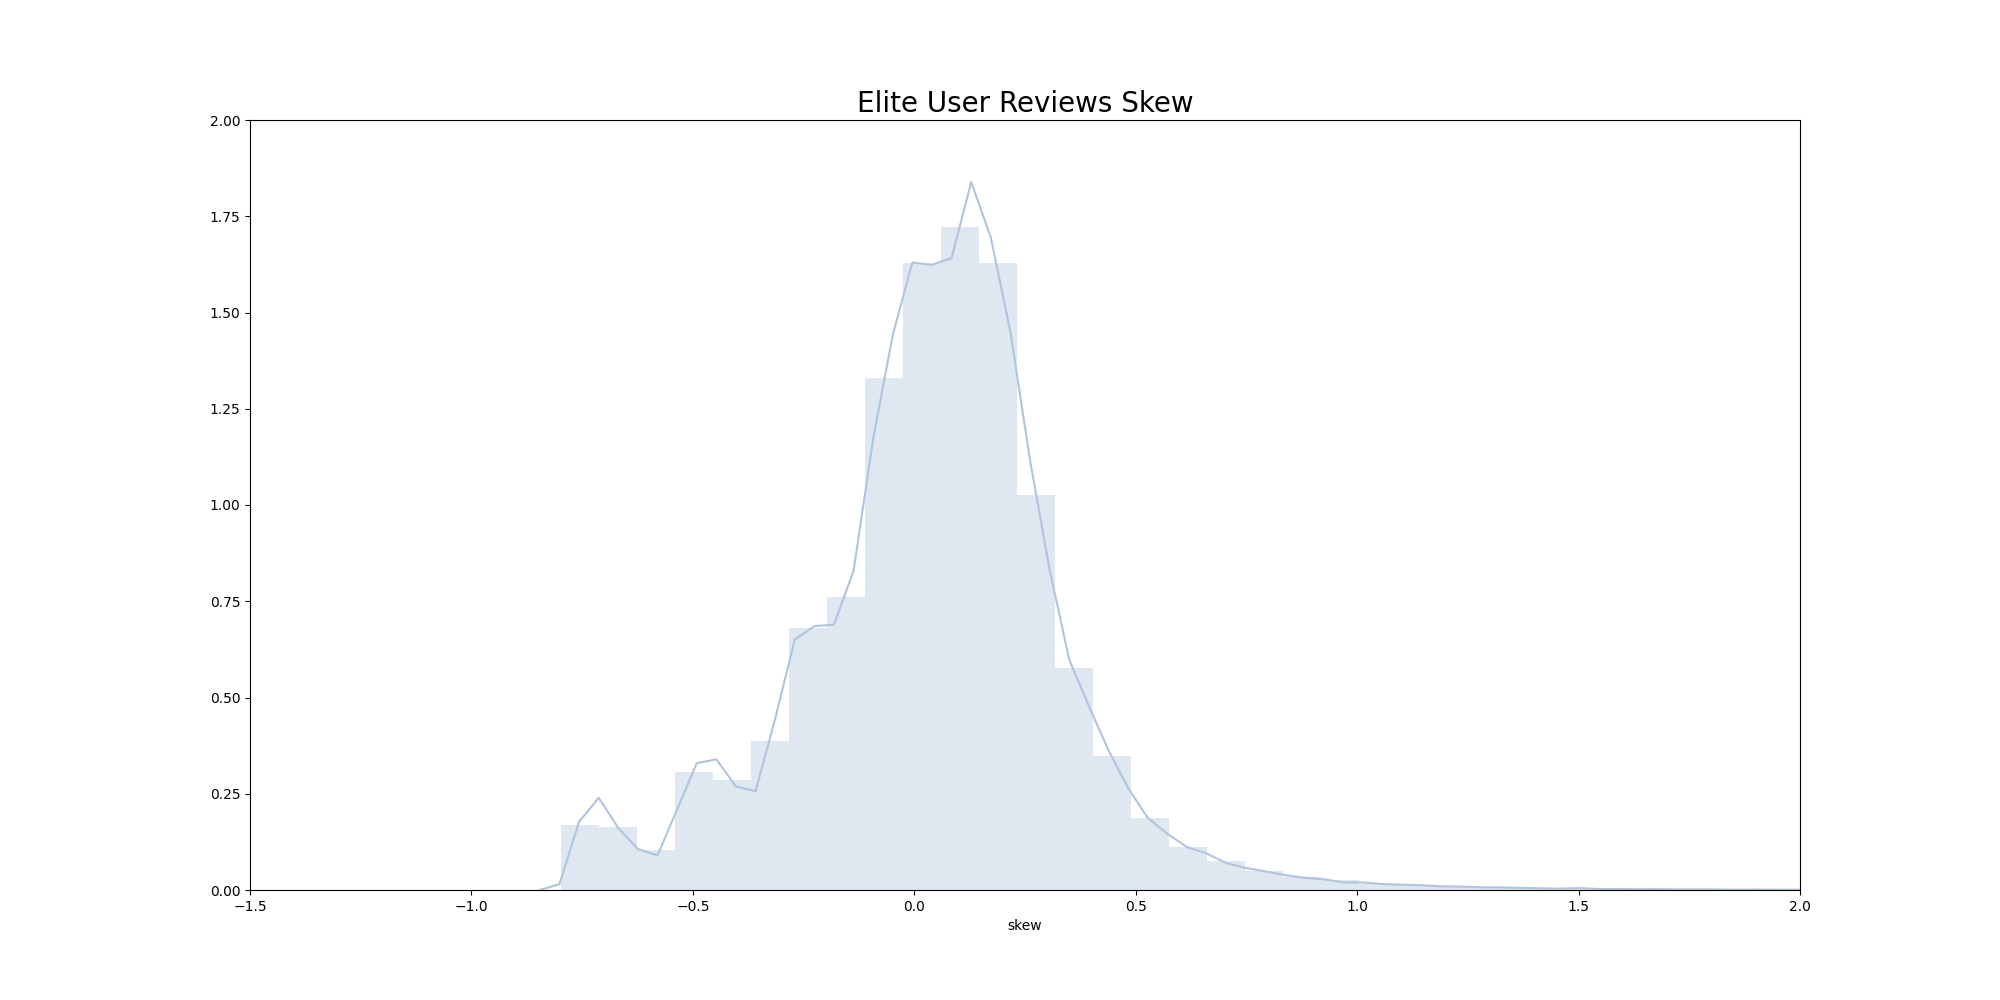

In [28]:
plt.figure(figsize=(20,10))
sns.distplot(elite_reviews_skew["skew"], kde=True, color = 'lightsteelblue')
plt.title('Elite User Reviews Skew', size = 20)
plt.axis((-1.5, 2, 0, 2))

%matplot plt

### Interpretation

Although the skew appears to be normal, if observed carefully, it is negatively skewed. To be sure, I calculated the skewness using the formula skewness = (3 * (mean-median) / std_dev) below

In [29]:
mean = elite_reviews_skew['skew'].mean()
median = elite_reviews_skew['skew'].median()
std_dev = elite_reviews_skew['skew'].std()
skewness = (3 * (mean-median) / std_dev).round(2)

print('Skewness: ', skewness)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Skewness:  -0.19

This proves that the skewness is negative, which means the Elite users are slightly less satisfied than the reviews they give. 